# 비선형추정 (1)

## spline 기법
-   구간을 나눠서 직선을 피팅하는 방법
  -   단점1: 미분이 안된다.
  -   단점2: 각 구간별 직선이 로컬(local) 하게 적용된다.
-   즉, knot (갈라지는 점)에 따라 너무 모양이 많이 달라진다.

그래서, Spline을 강화시켜야 한다.
- knot의 갯수를 잘 조절해야 한다. 
- 이를 smoothing scatterplot (산점도 평활화) 이라고 한다.

## loess procedures
-   local regression의 약자.
-   데이터의 어떤 점을 기준으로 그 근방의 값(local)에 대해 회귀
-   g를 추정하는 방법 : 모수와 SSE를 이용한다.

$$
y_i = g(x_i) + \epsilon
$$

-   대표적인 산점도 평활화 기법.
    1.  윈도우를 이용해 구간을 설정
    2.  함수를 피팅 (윈도우가 클 수록 차수가 늘어난다)
    3.  피팅된 선들의 평균을 구한다.
    4.  평균들을 연결!

그런데 윈도우가 너무 크면, 이상한 직선이 생길 수 있다.
- 이를 피하는 방법 : 가중치를 적게 주면 가능하다.
- 가중치 = 거리의 절댓값의 역수.
- knot ($x_0$)을 계속 이동시켜 전체적인 curve를 그리는 것이 목표

# 예시 (1)
## 데이터 준비

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import platform
from matplotlib import rcParams

# 운영 체제에 따라 한글 폰트 설정
os_name = platform.system()
if os_name == 'Darwin':  # macOS
    rcParams['font.family'] = 'AppleGothic'
elif os_name == 'Windows':
    rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    rcParams['font.family'] = 'NanumGothic'

In [28]:
# 임의의 데이터 생성
np.random.seed(0)
X = np.linspace(10, 100, 100)
# sin 함수와 2차식 혼합
y = 0.5 * X + 10 * np.sin(0.1 * X) + 0.01 * X**2 + np.random.normal(size=X.shape)

# 데이터프레임 생성
df = pd.DataFrame({'Temperature': X, 'Ozone': y})

## 산점도 그리기

In [32]:
# 선형 회귀 모델 적합
linear_model = LinearRegression()
linear_model.fit(df[['Temperature']], df['Ozone'])

# LOESS 모델 적합
lowess = sm.nonparametric.lowess
loess_fit = lowess(df['Ozone'], df['Temperature'], frac=0.3)  # frac 조정 가능

# 예측값 생성
X_pred = np.linspace(df['Temperature'].min(), df['Temperature'].max(), 100)
X_pred_df = pd.DataFrame({'Temperature': X_pred})  # DataFrame으로 변환
y_pred = linear_model.predict(X_pred_df)  # DataFrame을 사용하여 예측

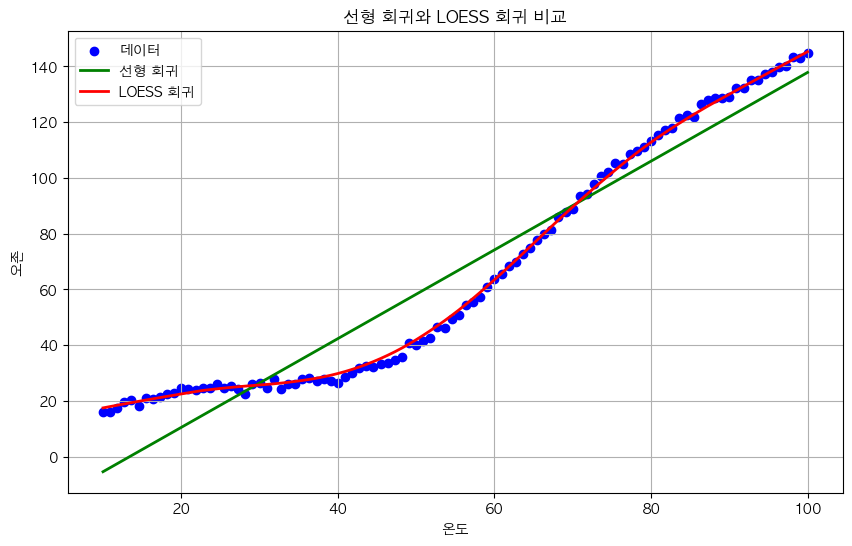

In [33]:
# 결과 플로팅
plt.figure(figsize=(10, 6))

# 산점도
plt.scatter(df['Temperature'], df['Ozone'], label='데이터', color='blue')

# 선형 회귀 직선
plt.plot(X_pred, y_pred, color='green', label='선형 회귀', linewidth=2)

# LOESS 회귀 직선
plt.plot(loess_fit[:, 0], loess_fit[:, 1], color='red', label='LOESS 회귀', linewidth=2)

plt.xlabel('온도')
plt.ylabel('오존')
plt.title('선형 회귀와 LOESS 회귀 비교')
plt.legend()
plt.grid(True)
plt.show()

## 결과해석 : 직선 fit vs loess fit

1. loess fit
    - 일반적인 직선보다 더 분포를 잘 반영한다.
    - 단, loess는 정렬을 하지 않으면 데이터가 엉망이 된다.
2. 이웃의 넓이에 따른 loess fit의 차이
    - 구간이 넓으면 좀 더 smooth한 곡선이 그려진다.

## 신뢰구간
* 잭나이프법이나 부트스트래핑을 이용, 신뢰구간을 구하는 것
* 완벽한 신뢰구간을 구할 수 없는 loess 기법에서 자주 사용한다.

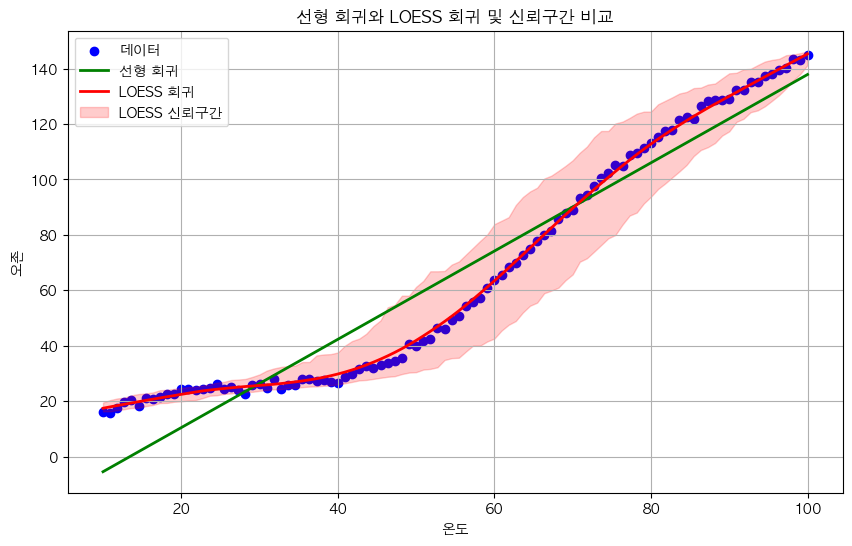

In [34]:
# 신뢰구간을 계산하기 위한 bootstrap 함수
def bootstrap_loess(df, frac=0.3, n_bootstrap=100):
    bootstrapped = []
    for _ in range(n_bootstrap):
        sample = df.sample(frac=1, replace=True)  # 부트스트랩 샘플링
        loess = sm.nonparametric.lowess(sample['Ozone'], sample['Temperature'], frac=frac)
        bootstrapped.append(loess[:, 1])
    bootstrapped = np.array(bootstrapped)
    ci_lower = np.percentile(bootstrapped, 2.5, axis=0)
    ci_upper = np.percentile(bootstrapped, 97.5, axis=0)
    return ci_lower, ci_upper

# 신뢰구간 계산
ci_lower, ci_upper = bootstrap_loess(df, frac=0.3, n_bootstrap=100)

# 예측값 생성
X_pred = np.linspace(df['Temperature'].min(), df['Temperature'].max(), 100)
X_pred_df = pd.DataFrame({'Temperature': X_pred})  # DataFrame으로 변환
y_pred = linear_model.predict(X_pred_df)  # DataFrame을 사용하여 예측

# LOESS 회귀를 예측값으로 보간
loess_fit_pred = lowess(df['Ozone'], df['Temperature'], frac=0.3, return_sorted=False)

# 결과 플로팅
plt.figure(figsize=(10, 6))

# 산점도
plt.scatter(df['Temperature'], df['Ozone'], label='데이터', color='blue')

# 선형 회귀 직선
plt.plot(X_pred, y_pred, color='green', label='선형 회귀', linewidth=2)

# LOESS 회귀 직선
plt.plot(loess_fit[:, 0], loess_fit[:, 1], color='red', label='LOESS 회귀', linewidth=2)

# LOESS 회귀 신뢰구간
plt.fill_between(loess_fit[:, 0], ci_lower, ci_upper, color='red', alpha=0.2, label='LOESS 신뢰구간')

plt.xlabel('온도')
plt.ylabel('오존')
plt.title('선형 회귀와 LOESS 회귀 및 신뢰구간 비교')
plt.legend()
plt.grid(True)
plt.show()